In [101]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

데이터 불러오기

In [102]:
data_path= "../data"
signal_name = 'signal2'
file_num = 10 # 들고올 파일의 개수
csv_cnt ={1:"*999.csv",10:"*99.csv",100:"*9.csv",1000:".csv"} # 하나의 종류에 파일이 총 100개일 때 
normal_files = glob.glob(data_path+'/'+signal_name+'/normal/'+csv_cnt[file_num])
anormal_drift_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/drift/'+csv_cnt[file_num])
anormal_erratic_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/erratic/'+csv_cnt[file_num])
anormal_hardover_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/hardover/'+csv_cnt[file_num])
anormal_spike_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/spike/'+csv_cnt[file_num])
anormal_stuck_files = glob.glob(data_path+'/'+signal_name+'/normal+anormal/stuck/'+csv_cnt[file_num])
#print(anormal_drift_files)

def dataReader(path_names):
    data_n = pd.DataFrame() #판다스의 데이터프레임 형태로 프레임 생성
    for i in path_names:
        low_data = pd.read_csv(i)# 판다스 형태로 읽음, 한csv파일씩 읽기 떄문에 다음 라인에서 하나로 합침
        data_n = pd.concat([data_n,low_data],ignore_index=True)
    return data_n

normal_datas = dataReader(normal_files)
drift_datas = dataReader(anormal_drift_files)
erratic_datas = dataReader(anormal_erratic_files)
hardover_datas = dataReader(anormal_hardover_files)
spike_datas = dataReader(anormal_spike_files)
stuck_datas = dataReader(anormal_stuck_files)
#print(drift_datas)

data shape 변경

In [103]:
#LSTM, LSTM-AE
def X_to_XyLSTM_shape(X,ntime_in,ntime_after): #X변형할 시계열 데이터 n_time_in 만큼 하나의 input으로 봄, ntime_out만큼 뒤에꺼를 예측
    nsample = len(X) - ntime_in -ntime_after 
    X_ntime = [0 for _ in range(nsample)]
    for i in range(nsample):
        X_ntime[i] = X[i:i+ntime_in]
    X_train = np.reshape(X_ntime,(nsample,ntime_in,1)) #2차원 배열을 3차원 배열으로
    #print('X',X_train.shape)
    y_nfuture = [0 for _ in range(nsample)]
    for i in range(nsample):
        after = i+ntime_in+ntime_after-1 # 배열 시작값이므로 -1
        y_nfuture[i] = X[after:after+1].values.flatten()
    y_train = np.array(y_nfuture)
    #print('y',y_train.shape)
    return X_train,y_train

모델생성

In [104]:
from tensorflow.python.keras.layers import InputLayer, Dense, LSTM
from tensorflow.python.keras.models import Sequential

n_time_in = 16 #16개의 데이터 입력으로 받음
ntime_after = 1 # ntime 후 값 예측

#LSTM_signal1 모델
LSTM_model_signal1 = Sequential()
LSTM_model_signal1.add(LSTM(128, input_shape=(n_time_in, 1)))
LSTM_model_signal1.add(Dense(1))
LSTM_model_signal1.compile(loss="mean_squared_error",optimizer='adam')


학습

In [105]:
series_data = normal_datas
X_LSTM_train, y_LSTM_train = X_to_XyLSTM_shape(series_data['value'],n_time_in,ntime_after)
"""
#datashape 변경확인
i= 5
print("X\n",X_LSTM_train[i])
print("y\n",y_LSTM_train[i])
print("series_data\n",series_data['value'][i+(n_time_in+ntime_after)-1]) #인덱스 이므로 -1
"""

'\n#datashape 변경확인\ni= 5\nprint("X\n",X_LSTM_train[i])\nprint("y\n",y_LSTM_train[i])\nprint("series_data\n",series_data[\'value\'][i+(n_time_in+ntime_after)-1]) #인덱스 이므로 -1\n'

In [106]:
i= 5
print("X\n",X_LSTM_train[i])
print("y\n",y_LSTM_train[i])
print("series_data\n",series_data['value'][i+(n_time_in+ntime_after)-1]) #인덱스 이므로 -1

X
 [[54.94851098]
 [51.45184679]
 [54.94350091]
 [53.07537328]
 [56.35719432]
 [56.54461855]
 [59.97626281]
 [59.83915273]
 [57.65612735]
 [58.00470525]
 [61.96609156]
 [59.28916553]
 [63.92937332]
 [62.78464763]
 [61.70190868]
 [63.26717602]]
y
 [63.61890444]
series_data
 63.6189044393063


In [107]:
LSTM_model_signal1.fit(X_LSTM_train,y_LSTM_train,epochs=10,batch_size=100,verbose=0)

추론

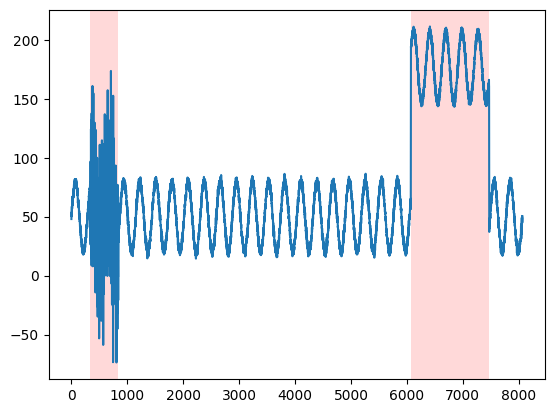

In [136]:
########################추론의 입력 데이터 정하기########################
predict_in_data = pd.concat([erratic_datas[:4032],hardover_datas[:4032]],ignore_index=True) #stuck_datas[:4032*2+1]

plt.plot(predict_in_data["value"])

# error값인경우 배경 빨강색
timeseries_data = [i for i in range(len(predict_in_data))]
for i in range(len(predict_in_data)):
    if predict_in_data['error'][i] != 0:
        plt.axvspan(xmin=timeseries_data[i] - 0.5, xmax=timeseries_data[i] + 0.5, facecolor='red', alpha=0.15)

# 그래프 표시
#plt.ylim(0,100)
plt.show()

In [137]:
############################### 추론 ##############################
X_LSTM_test,y_LSTM_test = X_to_XyLSTM_shape(predict_in_data['value'],n_time_in,ntime_after)
y_LSTM_predict = LSTM_model_signal1.predict(X_LSTM_test,verbose=0)
"""
i= 5
print("입력 X\n",X_LSTM_test[i])
print("입력 y\n",y_LSTM_test[i])
print("추론 y\n",y_LSTM_predict[i])
"""

'\ni= 5\nprint("입력 X\n",X_LSTM_test[i])\nprint("입력 y\n",y_LSTM_test[i])\nprint("추론 y\n",y_LSTM_predict[i])\n'

In [138]:
i= 0
print("입력 X\n",X_LSTM_test[i])
print("입력 y\n",y_LSTM_test[i])
print("추론 y\n",y_LSTM_predict[i])

입력 X
 [[47.97101582]
 [51.7509221 ]
 [51.70802288]
 [50.72895336]
 [51.83145976]
 [52.93831759]
 [53.95627524]
 [50.30129084]
 [58.68817791]
 [52.81415962]
 [54.88113697]
 [56.9526575 ]
 [59.60299882]
 [56.81430393]
 [59.16487188]
 [66.14311984]]
입력 y
 [61.35204858]
추론 y
 [60.902374]


오차 비교

In [139]:
def MSE(target,predict):
    return (1.0/2.0)*(target-predict)**2

In [140]:
input_size = len(predict_in_data["value"]) #입력된 데이터의 크기
test_size = len(y_LSTM_predict) # 테스트 데이터 크기 = 추론 데이터 크기 = 입력된 데이터의 크기 - (ntime_after+n_time_in)

In [141]:
#예측은 학습 데이터(timeseries_data)보다 ntime_after+n_time_in 뒤꺼예측하므로 plt 그림 그릴 때 구간 맞춰주려고
predict_time = [i-1 for i in range(ntime_after+n_time_in,input_size)]  # i-1
real_time = [i for i in range(input_size)]
#print(test_size)
#print(len(predict_time)) #test_size == len(test_time) 여야함
#print("start predict index", predict_time[0]) # 예측 시작 index
print(len(real_time))

8064


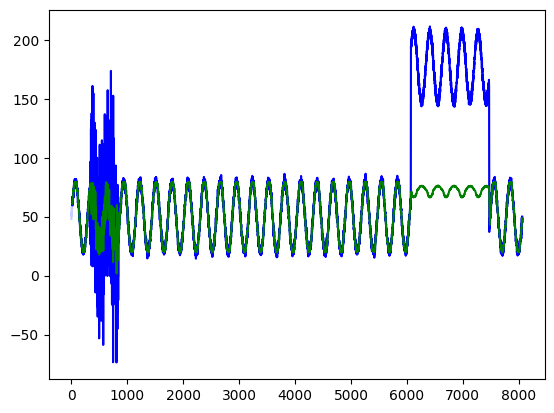

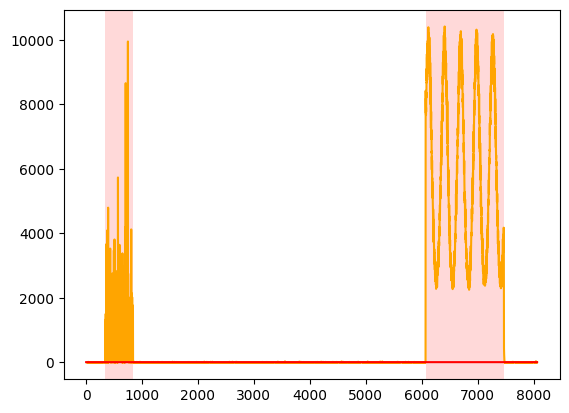

In [216]:
#전체 데이터
#예측 input data
plt.plot(real_time,predict_in_data["value"],c='blue', alpha=0.2) #입력되는 시계열 data
# 타겟 data
plt.plot(predict_time,y_LSTM_test,c='blue') # 타겟 data
#예측 output data
plt.plot(predict_time,y_LSTM_predict,c='green') #추론 결과
plt.show()
plt.close()

#타겟 예측 MSE
plt.plot(predict_time,MSE(y_LSTM_test,y_LSTM_predict),c='orange')
#threshold 그래프
threshold = 10
plt.plot([threshold for i in range(input_size)],c='red')
#오류부분 색칠
for i in range(len(predict_in_data)):
    if predict_in_data['error'][i] != 0:
        plt.axvspan(xmin=timeseries_data[i] - 0.5, xmax=timeseries_data[i] + 0.5, facecolor='red', alpha=0.15)
plt.show()
plt.close()

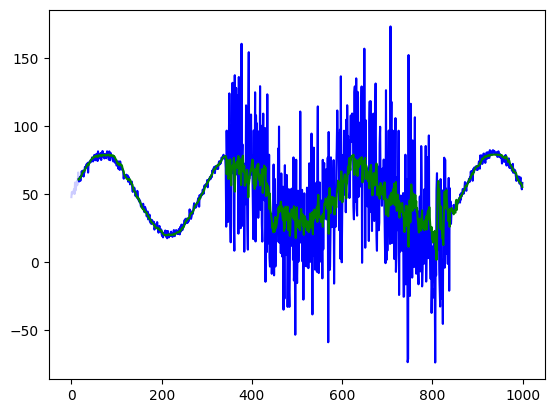

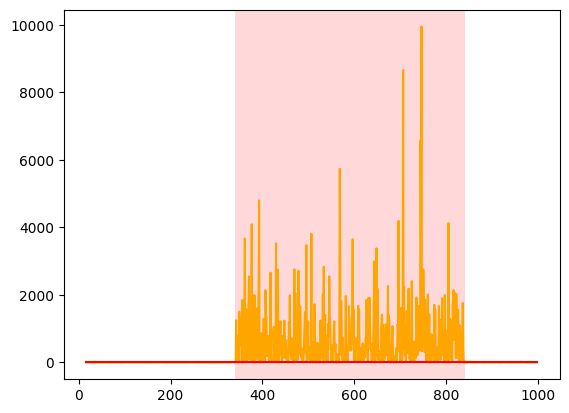

In [221]:
# 확대해서 보기
start =0
finish = 1000
#예측 input data
plt.plot(real_time[start:finish],predict_in_data["value"][start:finish],c='blue', alpha=0.2) #입력되는 시계열 data
# 타겟 data
plt.plot(predict_time[start:finish-n_time_in],y_LSTM_test[start:finish-n_time_in],c='blue') # 타겟 data
#예측 output data
plt.plot(predict_time[start:finish-n_time_in],y_LSTM_predict[start:finish-n_time_in],c='green') #추론 결과
plt.show()
plt.close()

#타겟 예측 MSE
plt.plot(predict_time[start:finish-n_time_in],MSE(y_LSTM_test,y_LSTM_predict)[start:finish-n_time_in],c='orange')

#threshold 그래프
threshold = 10
plt.plot(predict_time[start:finish-n_time_in],[threshold for i in range(input_size)][start:finish-n_time_in],c='red')
#오류부분 색칠
for i in range(start,finish):
    if predict_in_data['error'][i] != 0:
        plt.axvspan(xmin=timeseries_data[i] - 0.5, xmax=timeseries_data[i] + 0.5, facecolor='red', alpha=0.15)
plt.show()
plt.close()

In [222]:
#오차 시작과 끝
i = 0
while i < test_size:
    if predict_in_data['error'][i] != 0:
        print("start",i)
        while predict_in_data['error'][i] != 0:
            i = i+1
        print("finish",i)
    i = i + 1

start 342
finish 842
start 6070
finish 7470


In [223]:
###### 수동으로 구간 정해줘야 함 ######

# 에러 없는 구간
loss = LSTM_model_signal1.evaluate(X_LSTM_test[1000:5000], y_LSTM_test[1000:5000])
# 에러 구간
loss = LSTM_model_signal1.evaluate(X_LSTM_test[6000:7000], y_LSTM_test[6000:7000])

32/32 [==============================] - 0s 3ms/step - loss: 11511.5166


평가

In [224]:
mse = MSE(y_LSTM_test,y_LSTM_predict)


In [225]:
cnt = 0
start = 342 #
finish = 842 #
#threshold = 5
for i in range(start,finish):
    if mse[i] > threshold:
        cnt += 1

print("threshold",threshold)
print("=======================")
print("drift_datas")
print("Recall",round(100*cnt/(finish-start),2))

cnt = 0
start = 6070 #1962
finish = 7470 #2962
for i in range(start,finish):
    if mse[i] > threshold:
        cnt += 1
print("erratic_datas")
print("Recall",round(100*cnt/(finish-start),2))

cnt = 0
predict_cnt = 0
#threshold = 20
for i in range(test_size):
    if mse[i] > threshold:
        predict_cnt+= 1
        
        if predict_in_data['error'][i] != 0:
            cnt+=1
print("=======================")
print("total_datas")
print("Precision",round(100*cnt/predict_cnt,2))

threshold 10
drift_datas
Recall 88.2
erratic_datas
Recall 99.71
total_datas
Precision 86.57
